# Permutation Feature Importance on "Who's Going to Leave Next?"

<a id='source_1'></a>
<a id='source_2'></a>

In this notebook example, we will explain the global behavior of a classification model by identifying the most important features. To obtain the importance of the features, we will use the Permutation Importance explainer, initially proposed by  [Breiman (2001)](https://link.springer.com/article/10.1023/A:1010933404324)[[1]](#References), and further refined by [Fisher et al. (2019)](https://arxiv.org/abs/1801.01489)[[2]](#References).

This notebook is based on the following [blog post](https://lukesingham.com/whos-going-to-leave-next/).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

from alibi.explainers import PermutationImportance, plot_permutation_importance

### Read the dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ucg8j/kaggle_HR/master/HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


We will be using the `left` column as the target for the binary classification task. A value of 1 in the `left` column indicates that a person left the company.

In [3]:
# define target column
target_name = 'left'

# extract the features
feature_names = df.columns.to_list()
feature_names.remove(target_name)

# define categorical columns
categorical_names = [
    'Work_accident',           # binary
    'promotion_last_5years',   # binary
    'sales',                   # nominal
    'salary'                   # ordinal, but will treat it as nominal
]

# define numerical features
numerical_names = [ft for ft in feature_names if ft not in categorical_names]

Note that although the `salary` feature is ordinal, we will treat it as a nominal feature for the sake of this example.

### Data analysis

Before diving into the data preprocessing step and the actual model training, let us explore the dataset for a bit. We begin by inspecting the proportion of positive and negative instances in our dataset.

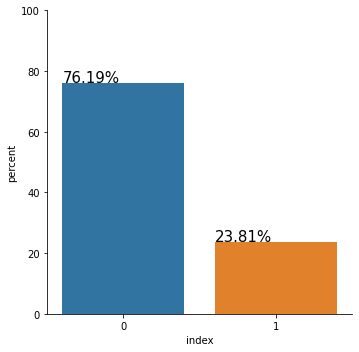

In [4]:
target_perc = df[target_name].value_counts(normalize=True).mul(100).rename('percent').reset_index()
g = sns.catplot(data=target_perc, x='index', y='percent', kind='bar')
g.ax.set_ylim(0, 100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x, txt_y = p.get_x(), p.get_height()
    g.ax.text(x=txt_x, y=txt_y, s=txt, fontdict={'size': 15})

Right away, we can observe that our dataset is quite imbalanced. The people who left the company represent the minority class, being just 23.81% of the entire dataset. Although might not the case for us, but usually when we have extreme class imbalance, we should consider carefully which metric to use to evaluate our classifier. For example, looking just at the accuracy might not be sufficient. Consider for example the case in which we have 99% of the data instance belonging to the negative class and 1% belonging to the positive class which is also the class of interest. A classifier predicting alway 0 will achieve an accuracy of 99%, although will be useless. Thus, in such a scenario, more appropriate metrics to look at will be the precision, the recall, and the $F_1$ score. In addition, one can also inspect the ROC AUC to measure the class separation.

Let us now inspect the relation between each feature and the target label. We begin by looking at the distribution of the numerical features grouped by labels.

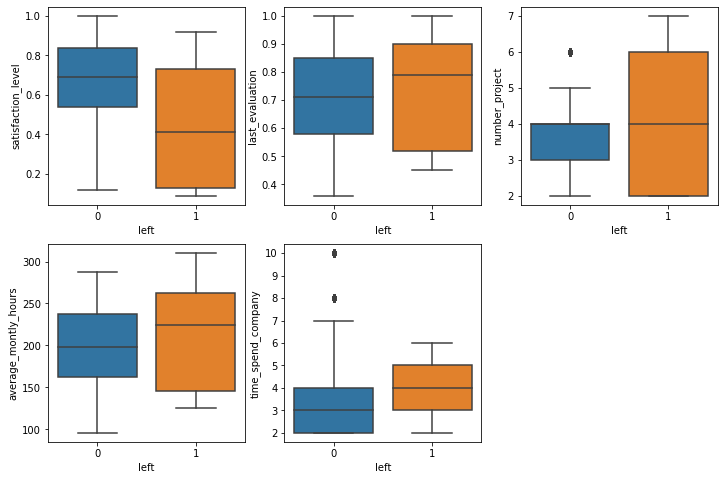

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs = axs.flatten()

for ax, ft in zip(axs, numerical_names):
    sns.boxplot(data=df, y=ft, x=target_name, ax=ax, orient='v')

fig.delaxes(axs[-1])

By inspecting the distribution above, we can already see some associations. Is probably not that surprising  that people with lower satisfaction level are more likely to leave. Similarly, people which work monthly on average more hours tend to leave the company. And finally, people that have been already for a while in the company have the same tendency to leave. All those associations make intuitive sense and one can come up with multiple plausible hypothesis on why this happens.

Quite interesting is the people who tend to have a higher evaluation score are also associate with leaving the company. Later when we will inspect the interactions between two features we might be able to come up with some explanations.

We continue by looking at the categorical features.

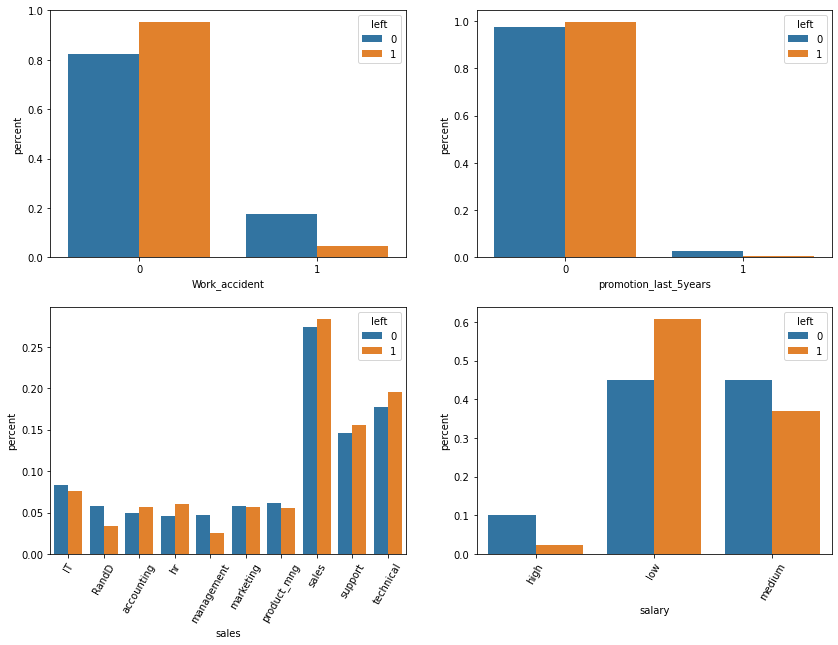

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for ax, ft in zip(axs, categorical_names):
    ser1 = df.groupby([target_name, ft])[target_name].count()
    ser2 = df.groupby([target_name])[target_name].count()
    df_prec = (ser1 / ser2).rename('percent').reset_index()
    sns.barplot(data=df_prec, x=ft, y='percent', hue=target_name, ax=ax)

axs[-2].tick_params(axis='x', rotation=60)
axs[-1].tick_params(axis='x', rotation=60)

We can observer that from the people with no work accidents, the percentage of people who leave the company is higher. Those are probably people who stay for a shorter period in the company and thus are less likely to experience a work accident. Looking at the `sales` plot, we can observer that there are a few categories which have a slightly higher chance to leave the company such as `'accounting'`, `'hr'`, `'sales'`, `'support'`, and `'technical'`. More obvious is the tendency in the `salary` plot in which people with `'low'` salaries are more likely to leave.

We continue our analysis by visualizing the interactions between two numerical features and their association with the target label.

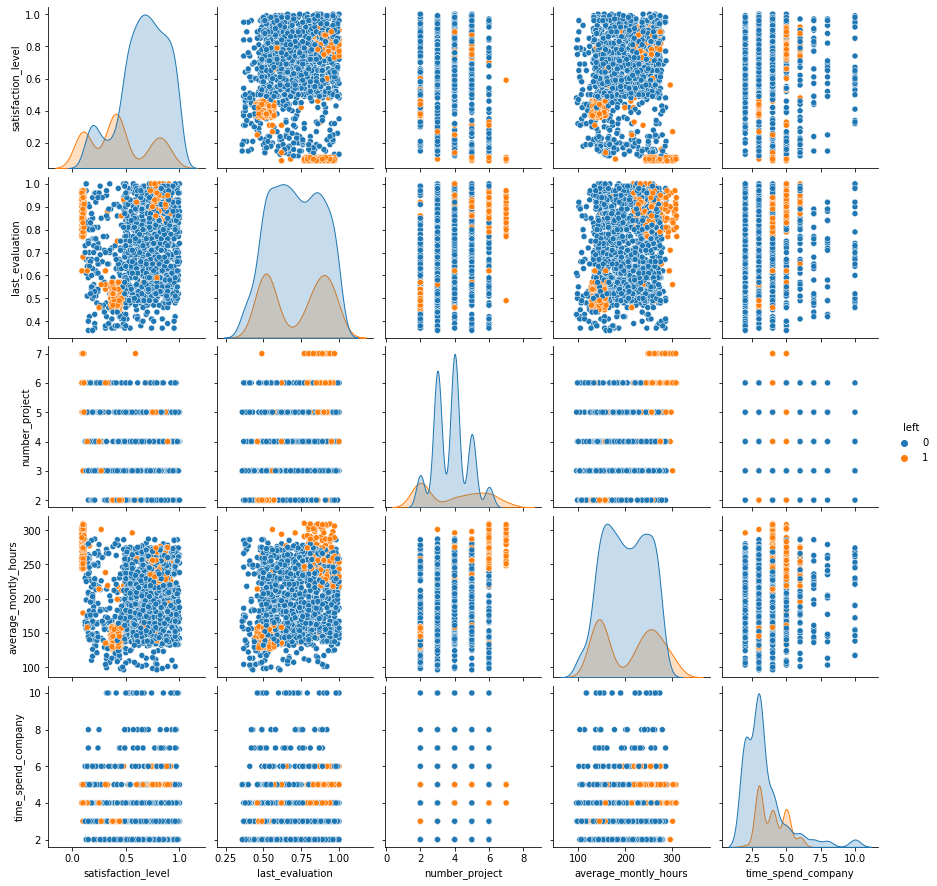

In [7]:
sns.pairplot(data=df.sample(frac=0.1), x_vars=numerical_names, y_vars=numerical_names, hue=target_name);

There are quite a few interaction which are wroth mentioning:

* (`satisfaction_level`, `last_evaluation`) - We can observe 3 groups which tend to leave the company. We have people with a satisfaction level around 0.4 and a last evaluation around 0.5. Those are people which are not very happy with their job and are not that great at their task, and thus it makes intuitive sense to leave the company as they might not be very productive. We also have people with a very low satisfaction level and a very high evaluation score. Those might be very skillful people which can easily find other opportunities  when they are not pleased anymore with their job. Finally, we have the relatively satisfied people with high performance evaluation which are probably the ones that are recruited by other with better offers.


* (`satisfaction_level`, `average_montly_hours`) - Analogous with the previous case, we identify three groups (might in fact coincide). The first group consists of people with a satisfaction level around 0.4 and who on average work monthly a relative number of hours. In the second group we have people who work a lot, but they are not very happy with their job. Finally, in the third group consists of relatively satisfied people who work a lot.


* (`last_evaluation`, `number_project`) - Here we distinguish two groups. The first group consists of people with a low evaluation score and a low number of projects which might not be very productive for the company. The second group consists of people with a high evaluation score and a high number of projects.


* (`last_evaluation`, `average_montly_hours`) - Similarly we can see two clear clusters defined by people with a low evaluation score and low number of average monthly hours, and the people with a high evaluation score and a high number of average monthly hours.

Although there are many other interaction to be mentioned, for the sake of this example we stop here. Similar investigation can be conducted for the categorical features. 

What we can conclude from the above analysis is that numerical features are quite relevant for the classification task.  

### Data preprocessing

We first split the dataset into train and test.

In [8]:
X = df[feature_names].to_numpy()
y = df[target_name].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

Define and fit the preprocessor. We use only one hot encoding for the categorical variables.

In [9]:
categorical_indices = [feature_names.index(ft) for ft in categorical_names]

# define categorical one-hot encoder
cat_transf = OneHotEncoder(
    categories=[np.unique(X_train[:, ft_idx]) for ft_idx in categorical_indices],
    drop='if_binary'
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_indices)
    ],
    remainder='passthrough',
    sparse_threshold=0,
    
)

# fit the preprocessor
preprocessor = preprocessor.fit(X_train)

With the preprocessor fitted, we compute the OHE representation of the training and testing dataset.

In [10]:
# get OHE data representation
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

### Train  and evaluate random forest classifier

Now that we have the dataset in a good format, we are ready to train the `RandomForestClassifier` from the `sklearn` library

In [11]:
rf = RandomForestClassifier(class_weight='balanced', random_state=0)
rf = rf.fit(X_train_ohe, y_train)

In [12]:
# evaluate classifier on train data
y_train_hat = rf.predict(X_train_ohe)
print(classification_report(y_true=y_train, y_pred=y_train_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999



In [13]:
# evaluate classifier on test data
y_test_hat = rf.predict(X_test_ohe)
print(classification_report(y_true=y_test, y_pred=y_test_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



As we can observe, our classifier performs reasonably well on all the metrics of interest.

### Permutation importance

With our classifier trained, we can perform post-hoc explanation to determine globally which are the most important features. We begin by defining prediction function followed by the `alibi` explainer.

In [14]:
def predict_fn(X: np.ndarray):
    return rf.predict(preprocessor.transform(X))

In [15]:
explainer = PermutationImportance(predictor=predict_fn,
                                  feature_names=feature_names,
                                  verbose=True)

We are now ready to compute the global importance of the features. If the list of feature is not provided, by default the explainer will compute the importance of every feature. Note that `alibi` supports some score function which can be specified through strings. By default the explainer uses the estimation method to compute the feature importance since is less computationally intensive, and reports the ratio between the base score and the permuted score.

In [16]:
exp = explainer.explain(X=X_test,
                        y=y_test,
                        score_fns=['accuracy', 'f1'])

100%|██████████| 9/9 [00:22<00:00,  2.45s/it]


To inspect the results, we can use the built-in `plot_permutation_importance` function.

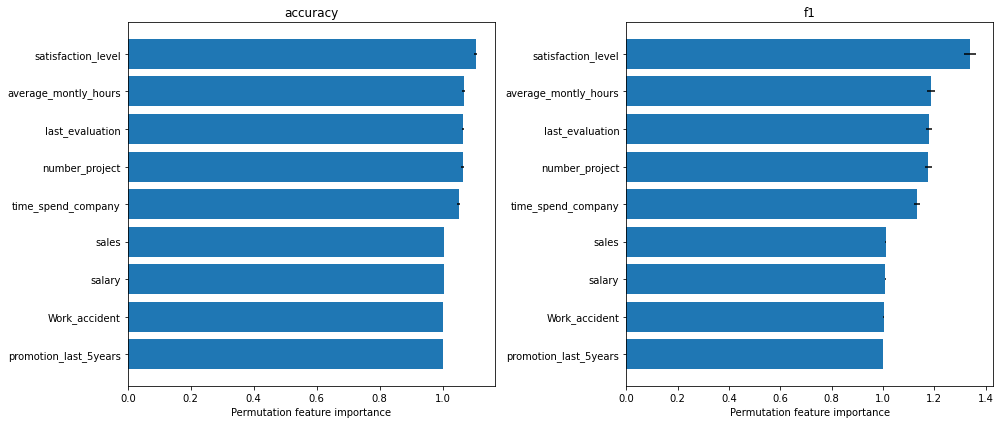

In [17]:
plot_permutation_importance(exp,
                            n_cols=2,
                            fig_kw={'figwidth': 14, 'figheight': 6});

We can also use custom score and loss functions apart from the ones already provided. 

For example, if we would like to use `1 - f1` metric, we need to define the corresponding loss function. In this case we can use the same explainer instance defined above because the output of the predictor is compatible with the loss function.

In [18]:
def loss_f1(y_true: np.ndarray, y_pred: np.ndarray):
    return 1 - f1_score(y_true=y_true, y_pred=y_pred)

In [19]:
exp_loss_f1 = explainer.explain(X=X_test,
                                y=y_test,
                                loss_fns={'1 - f1': loss_f1})

100%|██████████| 9/9 [00:22<00:00,  2.45s/it]


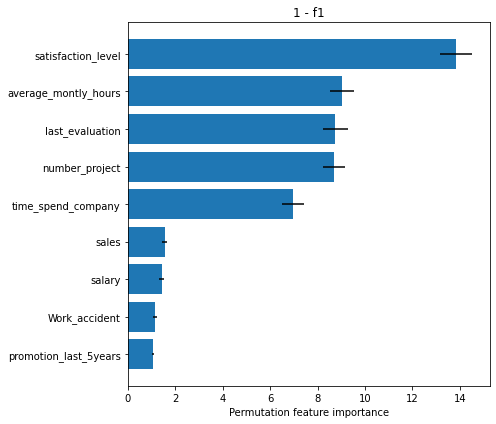

In [20]:
plot_permutation_importance(exp=exp_loss_f1,
                            fig_kw={'figwidth': 7, 'figheight': 6});

On the other hand, if we want to use the `1 - auc` metric we need to define the corresponding loss function, a new predictor which returns the probability of the positive class instead of the label, and thus will implicitly require to define a new explainer. Note that we need to define e new predictor because the output of the predictor must be compatible with the arguments expected by the loss function.

In [21]:
def loss_auc(y_true: np.ndarray, y_score: np.ndarray):
    return 1 - roc_auc_score(y_true=y_true, y_score=y_score)

def proba_fn(X: np.ndarray):
    return rf.predict_proba(preprocessor.transform(X))[:, 1]

In [22]:
explainer_loss_auc = PermutationImportance(predictor=proba_fn,
                                           feature_names=feature_names,
                                           verbose=True)

In [23]:
exp_loss_auc = explainer_loss_auc.explain(X=X_test,
                                          y=y_test,
                                          loss_fns={'1 - auc': loss_auc})

100%|██████████| 9/9 [00:22<00:00,  2.48s/it]


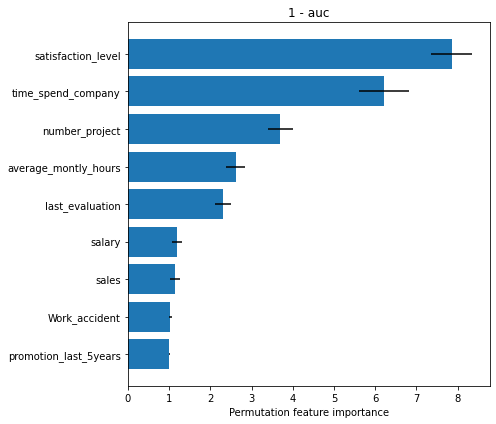

In [24]:
plot_permutation_importance(exp=exp_loss_auc,
                            fig_kw={'figwidth': 7, 'figheight': 6});

As we can observe from the plots above, the numerical features are quite important for the classification task which agrees with our analysis. Note that based on the metric used, the importance of the features and implicitly their ordering can differ. Nevertheless, we observe that the `satisfaction_level` feature seems to be consistently reported as the most important.

## References

<a id='References'></a>

[[1]](#source_1) Breiman, Leo. "Random forests." Machine learning 45.1 (2001): 5-32.

[[2]](#source_2) Fisher, Aaron, Cynthia Rudin, and Francesca Dominici. "All Models are Wrong, but Many are Useful: Learning a Variable's Importance by Studying an Entire Class of Prediction Models Simultaneously." J. Mach. Learn. Res. 20.177 (2019): 1-81.